# Description

ML-driven sentiment analysis is an important tool to understand communities’ feelings around major issues such as COVID-19. Gathering comprehensive social data for sentiment analysis can be limited, however, if data collection relies only on keywords such as ‘coronavirus’ or ‘covid’.

The objective of this project is to develop a machine learning model to assess if a Twitter post is about COVID-19 or not. This model will help gather tweet data about the epidemic without relying only on key words like ‘covid’ or ‘coronavirus’ being present, allowing researchers and engineers to gather a more comprehensive dataset for sentiment analysis.

This model could be put into practice as part of a larger effort to understand online sentiment around COVID-19, and inform future communications and public interventions by governments and non-government public health organisations.


# About
The objective of this project is to develop a machine learning model to assess if a Twitter post is about covid-19 or not.The data used for this project has been collected by the Zindi team via Twitter API from tweets over the past year. The are ~7,000 tweets in the train set and ~3,000 in the test set.

Tweets have been classified as covid-19-related (1) or not covid-19-related (0). All tweets have had the following keywords removed:

- corona
- coronavirus
- covid
- covid19
- covid-19
- sarscov2
- 19


The tweets have also had usernames and web addresses removed to ensure anonymity.

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_score
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [91]:
df = pd.read_csv("/Users/USER/Documents/DATASETS/covid_19_tweet_classification/Train.csv")
df.drop(['ID'], inplace=True, axis=1)
df.head()

,text,target
0,The bitcoin halving is cancelled due to,1
1,MercyOfAllah In good times wrapped in its gran...,0
2,266 Days No Digital India No Murder of e learn...,1
3,India is likely to run out of the remaining RN...,1
4,In these tough times the best way to grow is t...,0


<AxesSubplot:xlabel='count', ylabel='target'>

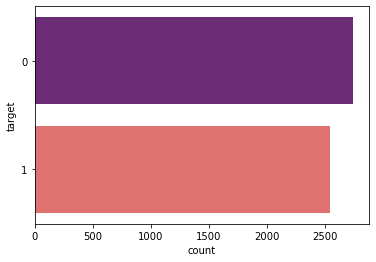

In [92]:
sns.countplot(data = df, y = 'target', palette = 'magma')

### MODEL BUILDING PROCESS:
- SPLIT DATA INTO TRAIN, VALIDATION AND TEST
- TRAIN INITIAL PIPELINE ON REDUCED TRAIN
- PERFORM HYPERPARAMETER TUNING ON VALIDATION SET
- THEN RETRAIN MODEL ON FULL TRAINING SET
- THEN TEST MODEL

In [111]:
x = df['text']
y = df['target']

In [112]:
x_train, xtest, y_train, ytest = train_test_split(x,y,test_size=0.15, random_state = 0)
xtrain, xval, ytrain, yval = train_test_split(x_train, y_train, test_size=0.50, random_state= 0)

xtest.shape, ytest.shape,xtrain.shape, ytrain.shape, yval.shape, xval.shape, 

((794,), (794,), (2246,), (2246,), (2247,), (2247,))

<AxesSubplot:>

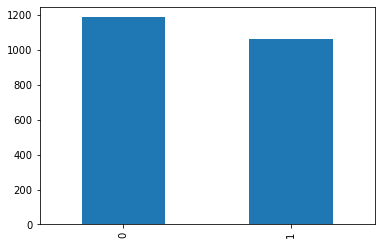

In [113]:
ytrain.value_counts().plot.bar()

In [114]:
pipe = Pipeline([('tfid',TfidfVectorizer()),('nb', MultinomialNB())])
pipe.fit(xtrain, ytrain)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('nb', MultinomialNB())])

In [115]:
ypred_initial = pipe.predict(xtrain)

In [116]:
print(classification_report(ytrain, ypred_initial))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1186
           1       0.99      0.94      0.96      1060

    accuracy                           0.96      2246
   macro avg       0.97      0.96      0.96      2246
weighted avg       0.97      0.96      0.96      2246



# HYPERPARAMETER TUNING

In [117]:
param_grid = {
    'tfid__ngram_range':[(1,1),(1,2),(1,3)],
    'nb__alpha':[0.1,0.2,1.0],
    'nb__fit_prior':[True, False]
}

In [118]:
#nb_pipe = Pipeline([('tfid',TfidfVectorizer()),('nb', MultinomialNB())])

In [129]:
grid = GridSearchCV(pipe, param_grid, scoring='precision', cv= 10).fit(xval, yval)

<IPython.core.display.Javascript object>

In [130]:
grid.best_estimator_

Pipeline(steps=[('tfid', TfidfVectorizer(ngram_range=(1, 3))),
                ('nb', MultinomialNB())])

In [131]:
grid.best_score_,grid.best_params_

(0.9184359132953881,
 {'nb__alpha': 1.0, 'nb__fit_prior': True, 'tfid__ngram_range': (1, 3)})

## TRAINING ON FULL DATASET

In [132]:
x_train.shape, y_train.shape

((4493,), (4493,))

In [133]:
final_model = Pipeline([('tfid',TfidfVectorizer(ngram_range=(1, 3))),
                        ('nb', MultinomialNB(alpha = 1.0, fit_prior = True))])

In [134]:
final_model.fit(x_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer(ngram_range=(1, 3))),
                ('nb', MultinomialNB())])

## TESTING

In [135]:
test_pred = final_model.predict(xtest)

In [136]:
print(classification_report(ytrain, ypred_initial))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1186
           1       0.99      0.94      0.96      1060

    accuracy                           0.96      2246
   macro avg       0.97      0.96      0.96      2246
weighted avg       0.97      0.96      0.96      2246



In [137]:
print('Training Precision:', precision_score(ytrain,ypred_initial ))
print('Validation Precision:',grid.best_score_)
print('Testing Precision:', precision_score(ytest,test_pred ))

Training Precision: 0.9880597014925373
Validation Precision: 0.9184359132953881
Testing Precision: 0.932475884244373


In [138]:
test = pd.concat([xtest, ytest], axis=1)
test['Predicted'] = test_pred
test

,text,target,Predicted
29,Thx a lot for the feedback I ll stress test it...,0,0
521,rinaldi According to the new Italian governmen...,0,0
608,Artist Juan Gim nez has died due to complicati...,1,1
4094,Am I in another universe The Prime Minister ma...,1,0
4683,GBPUSD gained traction for the fourth consecut...,1,1
...,...,...,...
1087,Protecting Those on the Frontline Aiding the m...,1,1
2949,SA Will it be safe for learners to knock off a...,1,0
3714,lockdown period is a enough rehabilitation per...,1,1
543,Jurnal Ramadan by A THREAD,0,0
